# NASA SPoRT SST vs. In-Situ Observations Jun 1. - Aug. 31
## Lake George, NY

1)  Time series plot of SPoRTS temps vs. in-situ temp obs

2)  Scatterplot of  SPoRTS temps vs. in-situ temp obs

     a) plot best fit line
     b) plot 1:1 reference line
     c) indicate  correlation coefficient value

3) Bar Graph of Mean Algebraic Error (Y axis)  vs. Time of Day (x axis)  [Hourly 0, 1, 2, ....23 UTC] for entire period
    purpose - to see if there is a diurnal bias in the SPoRTS temps)

4) Skill Statistics

     a) Mean Algebraic  Error 
     b) Mean Absolute Error
     b) RMSE

5) Map depicting the lakes in NE USA with a symbol indicating which lakes were evaluated in the study.

### Imports

In [1]:
import os, sys
import ast
from datetime import date, datetime, timedelta
from decimal import Decimal
from math import sqrt

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from pyproj import Transformer
import plotly
import plotly.graph_objects as go
import django
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import geopy.distance

In [2]:
# setup for django
sys.path.append(os.path.abspath(os.path.join('..', 'djangoapp')))
os.environ["DJANGO_SETTINGS_MODULE"] = "config.settings"
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()
from lib import utils
from api import models
from config.settings import PROJECT_BASE_DIR

## Get Data

In [3]:
# get lake model object
lake = models.Lake.objects.filter(name__contains='George').first()

In [4]:
# save plots as images or display in notebook
save_plots = False
FIG_DIR = os.path.join(PROJECT_BASE_DIR, 'figures', 'sport-sst-analysis', lake.name.replace(' ', ''))
plotly.io.orca.config.executable = os.path.join(PROJECT_BASE_DIR, 'orca-1.3.1.AppImage')

if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)

In [5]:
# load lake geometry from saved geojson
geom = [ shape(eval(lake.geojson)['features'][0]['geometry']) ]

lake_geom = gpd.GeoDataFrame({'geometry': geom})
lake_geom.crs = "EPSG:4326"
lake_geom = lake_geom.to_crs(epsg=3857)

### Lake Shape Map

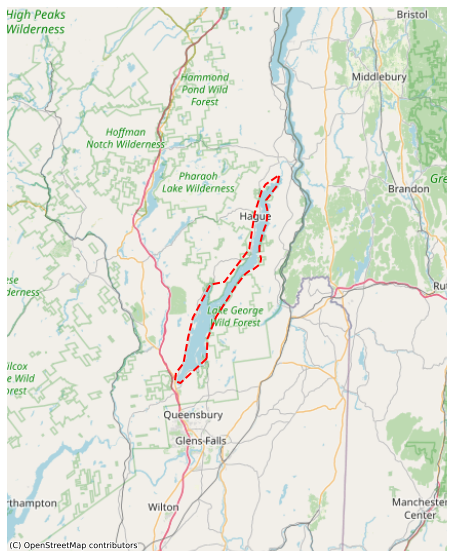

In [6]:
# plot lake boundary
fig= plt.figure(figsize=(10, 10))

ax = plt.plot(*lake_geom['geometry'][0].exterior.xy, color='red', linestyle='dashed', linewidth=2)
ax = plt.gca()

ax.set_xlim([ float(lake_geom.bounds['minx'])-50000, float(lake_geom.bounds['maxx'])+50000 ])
ax.set_ylim([ float(lake_geom.bounds['miny'])-50000, float(lake_geom.bounds['maxy'])+50000 ])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=9)
ax.set_axis_off()

if save_plots:
    plt.savefig(os.path.join(FIG_DIR, f"{lake.name.replace(' ', '')}-LakeShape-Map"), bbox_inches='tight')
else:
    plt.show()

### Get SPoRT SST Data

In [7]:
sst_lake_points = utils.get_sst_output_for_lake(lake, date(2020, 6, 1), date(2020, 8, 31))

/home/sean/source/hrrr-clm-lake-model-analysis/djangoapp/lib/utils.py:388: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  water_mask = sst_metadata.variables['Band1'][:].mask


In [8]:
# -3.76 is what would be a pixel value of 0 in the original tiff file
# seems to be the error value, makes the plots look terrible
sst_lake_points['water_temp'] = sst_lake_points['water_temp'].replace(Decimal('-3.76'), None)

### Get 5 SST Points Closest to In-Situ Station Location

In [9]:
# get station
station = models.Station.objects.filter(lake=lake).first()

In [10]:
# find distance from each point to station
dists = {}
for idx, group in sst_lake_points.groupby('grid_idx'):
    point = group['geometry'].unique()[0]
    dist = geopy.distance.geodesic((station.lon, station.lat), (point.x, point.y)).m
    dists[str(idx)] = dist

In [11]:
# sort points and get first 5
closest_5_idx = sorted(dists, key=dists.__getitem__)[:5]
closest_5_idx

['[2369, 5692]',
 '[2371, 5692]',
 '[2370, 5693]',
 '[2371, 5693]',
 '[2372, 5693]']

In [12]:
# create color palette for closest 5 points
palette = sns.color_palette('bright', 5)
closest_5_colormap = { idx: palette[i] for i, idx in enumerate(closest_5_idx) }

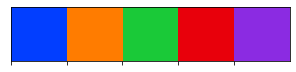

In [13]:
# colors in order assigned to closest 5 points
sns.palplot(sns.color_palette("bright", 5))

### SST Points and Station Location Map

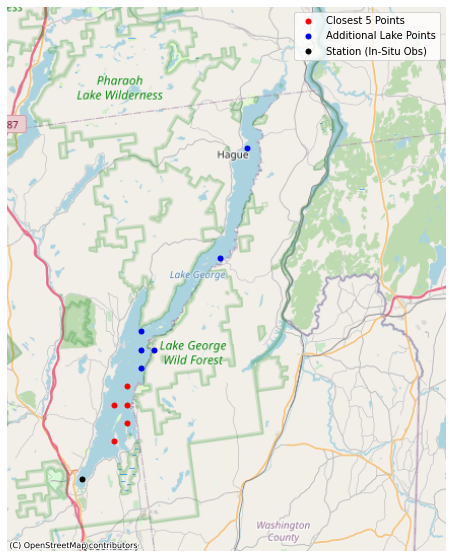

In [14]:
fig = plt.figure(figsize=(10, 10))

# plot lake points
transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
for idx in sst_lake_points['grid_idx'].unique():
    # convert from epsg:4326 to epsg:3857
    lon, lat = list(sst_lake_points[sst_lake_points['grid_idx'] == idx][['lon', 'lat']].iloc[0])
    x, y = transformer.transform(lat, lon)
    if idx in closest_5_idx:
        plt.plot(x, y, 'ok', markersize=5, color='red', label='Closest 5 Points')
    else:
        plt.plot(x, y, 'ok', markersize=5, color='blue', label='Additional Lake Points')

# plot station point
station_x, station_y = transformer.transform(station.lat, station.lon)
plt.plot(station_x, station_y, 'ok', markersize=5, color='black', label='Station (In-Situ Obs)')

ax = plt.gca()

ax.set_xlim([ float(lake_geom.bounds['minx'])-10000, float(lake_geom.bounds['maxx'])+25000 ])
ax.set_ylim([ float(lake_geom.bounds['miny'])-10000, float(lake_geom.bounds['maxy'])+10000 ])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
ax.set_axis_off()

utils.legend_without_duplicate_labels(ax)

if save_plots:
    plt.savefig(os.path.join(FIG_DIR, f"{lake.name.replace(' ', '')}-SPoRT-SST-AllPoints-Map"), bbox_inches='tight')
else:
    plt.show()

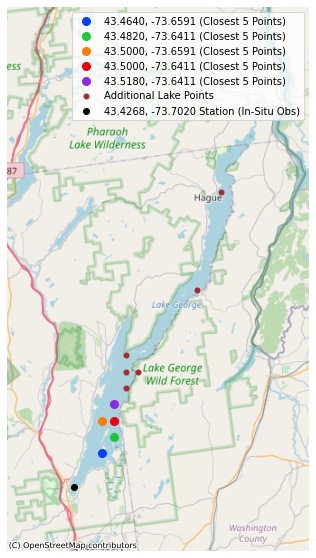

In [15]:
fig = plt.figure(figsize=(10, 10))

# plot lake points
transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
for idx in sst_lake_points['grid_idx'].unique():
    # convert from epsg:4326 to epsg:3857
    lon, lat = list(sst_lake_points[sst_lake_points['grid_idx'] == idx][['lon', 'lat']].iloc[0])
    x, y = transformer.transform(lat, lon)
    if idx in closest_5_idx:
        plt.plot(x, y, 'ok', markersize=8, color=closest_5_colormap[idx], label=f"{lat}, {lon} (Closest 5 Points)")
    else:
        plt.plot(x, y, 'ok', markersize=5, color='brown', label='Additional Lake Points')

# plot station point
station_x, station_y = transformer.transform(station.lat, station.lon)
plt.plot(station_x, station_y, 'ok', markersize=6, color='black', label=f"{station.lat}, {station.lon} Station (In-Situ Obs)")

ax = plt.gca()

ax.set_xlim([ float(lake_geom.bounds['minx'])-10000, float(lake_geom.bounds['maxx'])+10000 ])
ax.set_ylim([ float(lake_geom.bounds['miny'])-10000, float(lake_geom.bounds['maxy'])+20000 ])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
ax.set_axis_off()

utils.legend_without_duplicate_labels(ax)

if save_plots:
    plt.savefig(os.path.join(FIG_DIR, f"{lake.name.replace(' ', '')}-SPoRT-SST-AllPointsClosestColored-Map"), bbox_inches='tight')
else:
    plt.show()

### 5 Closest Points and Station Location Map

Note: the colors of the points on this map correspond to their colors in the plots below.

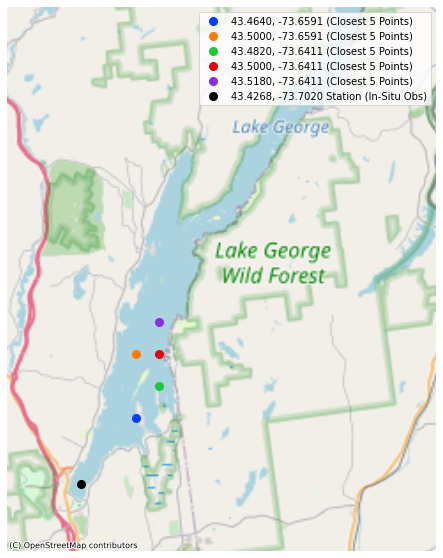

In [16]:
fig = plt.figure(figsize=(10, 10))

# plot lake points
transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
for idx in closest_5_idx:
    # convert from epsg:4326 to epsg:3857
    lon, lat = list(sst_lake_points[sst_lake_points['grid_idx'] == idx][['lon', 'lat']].iloc[0])
    x, y = transformer.transform(lat, lon)
    plt.plot(x, y, 'ok', markersize=8, color=closest_5_colormap[idx], label=f"{lat}, {lon} (Closest 5 Points)")

# plot station point
station_x, station_y = transformer.transform(station.lat, station.lon)
plt.plot(station_x, station_y, 'ok', markersize=8, color='black', label=f"{station.lat}, {station.lon} Station (In-Situ Obs)")

ax = plt.gca()

ax.set_xlim([ float(lake_geom.bounds['minx'])-5000, float(lake_geom.bounds['maxx'])+1000 ])
ax.set_ylim([ float(lake_geom.bounds['miny'])-5000, float(lake_geom.bounds['maxy'])-20000 ])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
ax.set_axis_off()

utils.legend_without_duplicate_labels(ax)

if save_plots:
    plt.savefig(os.path.join(FIG_DIR, f"{lake.name.replace(' ', '')}-SPoRT-SST-Closest5Points-Map"), bbox_inches='tight')
else:
    plt.show()

### Get In-Situ Data

In [17]:
# load cayuga data from csv
# column names to correspond with reusable code blocks
insitu_data = pd.read_csv('../data/insitu/LG Water Temperature 2020.csv', skiprows=1, parse_dates=[0], names=['datetime', 'water_temp'])

# localize datetime
insitu_data['datetime'] = insitu_data['datetime'].dt.tz_localize('utc')

# convert temp to C
insitu_data['water_temp'] = (insitu_data['water_temp'] - 32) * (5/9)

insitu_data.head()

datetime  water_temp
0 2020-06-05 11:18:08+00:00   14.061111
1 2020-06-05 12:18:34+00:00   14.377778
2 2020-06-05 13:12:16+00:00   14.561111
3 2020-06-05 13:15:37+00:00   14.561111
4 2020-06-05 14:09:20+00:00   14.250000

## All SPoRTS SST Temps vs. In-Situ Temp Obs Timeseries

In [18]:
# Create traces
fig = go.Figure()

for idx in sst_lake_points['grid_idx'].unique():
    points = sst_lake_points[sst_lake_points['grid_idx'] == idx]
    color_str = f"rgb({','.join(map(lambda x : str(int(x)), 255*np.array(closest_5_colormap[idx])))})" if idx in closest_5_idx else None
    fig.add_trace(
        go.Scatter(
            x=points['datetime'],
            y=points['water_temp'],
            mode='lines',
            name=(f"{points.iloc[0]['lat']}, {points.iloc[0]['lon']}") + (' (closest 5)' if idx in closest_5_idx else ''),
            line={ 'color': color_str }
        )
    )
    

fig.add_trace(
    go.Scatter(
        x=insitu_data['datetime'],
        y=insitu_data['water_temp'],
        mode='lines',
        name="In-Situ",
        line={ 'color': 'black' }
    )
)

fig.update_layout(
    title=f"SST Lake Model Cycles 06 and 18 and In-Situ Temp for {lake.name} from June 1, 2020 - Aug 31, 2020",
    xaxis_title="Date",
    yaxis_title="Water Temp (C)",
    xaxis = {
        'dtick': 3600000.0*24#*7
    },
    width=1920, 
    height=1080
)
fig.update_traces(connectgaps=False)

if save_plots:
    fig.write_image(os.path.join(FIG_DIR, f"{lake.name.replace(' ', '')}-SPoRT-SST-20200601-20200831-AllPoints-Timeseries.png"))
else:
    fig.show()

## Closest 5 SPoRTS SST Temps vs. In-Situ Temp Obs Timeseries

In [19]:
# Create traces
fig = go.Figure()

for idx in closest_5_idx:
    points = sst_lake_points[sst_lake_points['grid_idx'] == idx]
    color_str = f"rgb({','.join(map(lambda x : str(int(x)), 255*np.array(closest_5_colormap[idx])))})"
    fig.add_trace(
        go.Scatter(
            x=points['datetime'],
            y=points['water_temp'],
            mode='lines',
            name=f"{points.iloc[0]['lat']}, {points.iloc[0]['lon']}",
            line={ 'color': color_str }
        )
    )
    

fig.add_trace(
    go.Scatter(
        x=insitu_data['datetime'],
        y=insitu_data['water_temp'],
        mode='lines',
        name="In-Situ",
        line={ 'color': 'black' }
    )
)

fig.update_layout(
    title=f"Closest 5 SST Lake Model Points (Cycles 06 and 18) and In-Situ Temp for {lake.name} from June 1, 2020 - Aug 31, 2020",
    xaxis_title="Date",
    yaxis_title="Water Temp (C)",
    xaxis = {
        'dtick': 3600000.0*24#*7
    },
    width=1920, 
    height=1080
)
fig.update_traces(connectgaps=False)

if save_plots:
    fig.write_image(os.path.join(FIG_DIR, f"{lake.name.replace(' ', '')}-SPoRT-SST-20200601-20200831-Closest5Points-Timeseries.png"))
else:
    fig.show()

### Build arrays for comparison

In [20]:
# get closest insitu ob for each sst datetime
true_arr = []
for sst_dt in sst_lake_points['datetime'].unique(): # data for most of Jun 1 - 8 is missing
    # get obs closest to sst pred
    result = utils.find_neighbours(insitu_data, 'datetime', sst_dt)
    
    if not isinstance(result, list): # exact match
        match = insitu_data.iloc[result]

    else:
        lower_ind, upper_ind = result

        # get neighbors
        lower_neigh = insitu_data.iloc[lower_ind]
        upper_neigh = insitu_data.iloc[upper_ind]

        # get timedelta between neighbors and sst datetime
        lower_delta = sst_dt - lower_neigh['datetime']
        upper_delta = upper_neigh['datetime'] - sst_dt

        # check if insitu obs are close enough to compare
        if lower_delta.seconds > 7200 and upper_delta.seconds > 7200: # two hours
            true_arr.append({
                'sst_dt': sst_dt,
                'insitu_avail': False
            })
            continue

        # get closer ob
        match = lower_neigh if lower_delta.seconds < upper_delta.seconds else upper_neigh
    
    # check temp is valid
    if np.isnan(match['water_temp']):
        true_arr.append({
            'sst_dt': sst_dt,
            'insitu_avail': False
        })
        continue
    else:
        # build row
        true_arr.append({
            'sst_dt': sst_dt,
            'insitu_avail': True,
            'insitu_dt': match['datetime'],
            'insitu_temp': match['water_temp']
    #         'insitu_lower_dt': lower_neigh['datetime'],
    #         'insitu_lower_temp': lower_neigh['water_temp'],
    #         'insitu_upper_dt': upper_neigh['datetime'],
    #         'insitu_upper_temp': upper_neigh['water_temp'],
    #         'insitu_avg': np.mean([ lower_neigh['water_temp'], upper_neigh['water_temp'] ]),
        })

true_df = pd.DataFrame(true_arr)
true_df.head()

sst_dt  insitu_avail insitu_dt  insitu_temp
0 2020-06-01 06:00:00+00:00         False       NaT          NaN
1 2020-06-01 18:00:00+00:00         False       NaT          NaN
2 2020-06-02 06:00:00+00:00         False       NaT          NaN
3 2020-06-02 18:00:00+00:00         False       NaT          NaN
4 2020-06-03 06:00:00+00:00         False       NaT          NaN

In [21]:
# get closest 5 sst lake points
pred_df = sst_lake_points[sst_lake_points['grid_idx'].isin(closest_5_idx)].sort_values(by='datetime')

# remove sst points that are missing from insitu data
pred_df = pred_df[pred_df['datetime'].isin(true_df[true_df['insitu_avail']]['sst_dt'])]

pred_df.head()

id  lake_id      grid_idx       lon      lat  \
99   91364      115  [2369, 5692]  -73.6591  43.4640   
100  91365      115  [2370, 5693]  -73.6411  43.4820   
101  91366      115  [2371, 5692]  -73.6591  43.5000   
102  91367      115  [2371, 5693]  -73.6411  43.5000   
103  91368      115  [2372, 5693]  -73.6411  43.5180   

                     datetime water_temp                    geometry  
99  2020-06-05 18:00:00+00:00      15.44  POINT (-73.65910 43.46400)  
100 2020-06-05 18:00:00+00:00      15.44  POINT (-73.64110 43.48200)  
101 2020-06-05 18:00:00+00:00      15.44  POINT (-73.65910 43.50000)  
102 2020-06-05 18:00:00+00:00      15.44  POINT (-73.64110 43.50000)  
103 2020-06-05 18:00:00+00:00      17.24  POINT (-73.64110 43.51800)

In [22]:
# make sure arrays are the same length
print(len(pred_df['datetime'].unique()))
print(len(true_df[true_df['insitu_avail']]['insitu_temp'].values))

153
153


In [23]:
# convert 'water_temp' column to numeric type so it can be averaged over
pred_df['water_temp'] = pd.to_numeric(pred_df['water_temp'])# , errors ='ignore')

In [24]:
# average closest 5 SST points for 0600 and 1800
pred_arr = pred_df.groupby('datetime')['water_temp'].mean()
pred_arr

datetime
2020-06-05 18:00:00+00:00    15.80
2020-06-06 06:00:00+00:00    15.40
2020-06-07 06:00:00+00:00    15.80
2020-06-07 18:00:00+00:00    15.64
2020-06-09 06:00:00+00:00    16.00
                             ...  
2020-08-29 18:00:00+00:00    24.44
2020-08-30 06:00:00+00:00    24.00
2020-08-30 18:00:00+00:00    24.44
2020-08-31 06:00:00+00:00    23.48
2020-08-31 18:00:00+00:00    24.08
Name: water_temp, Length: 153, dtype: float64

## Average of Closest 5 SPoRTS SST Temps vs. In-Situ Temp Obs Scatterplot

    a) plot best fit line
    b) plot 1:1 reference line
    c) indicate  correlation coefficient value

In [25]:
# get best fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(true_df[true_df['insitu_avail']]['insitu_temp'].values, pred_arr.values)
line = slope*true_df[true_df['insitu_avail']]['insitu_temp'].values + intercept

In [26]:
# Create traces
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=true_df[true_df['insitu_avail']]['insitu_temp'].values,
        y=pred_arr.values,
        mode='markers',
        name="(Ob, SPoRT)"
    )
)

fig.add_trace(
    go.Scatter(
        x=true_df[true_df['insitu_avail']]['insitu_temp'].values,
        y=line,
        mode='lines',
        name="Best Fit"
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(14, 27)),
        y=list(range(14, 27)),
        mode='lines',
        name="1:1 Reference"
    )
)


fig.add_annotation(
    x=16, 
    y=25,
    text=f"Best Fit: R^2 = {r_value**2:.3}, Y = {slope:.3}X + {intercept:.3}",
    showarrow=False,
    yshift=10,
    font={
        'size': 16
    }
)


fig.update_layout(
    title=f"In-situ Obs vs SPoRT Composite for {lake.name} from June 1, 2020 - Aug 31, 2020",
    xaxis_title="Observed (C)",
    yaxis_title="SPoRT Composite (C)",
    width=966,
    height=525
)
fig.update_traces(connectgaps=False)

if save_plots:
    fig.write_image(os.path.join(FIG_DIR, f"{lake.name.replace(' ', '')}-SPoRT-SST-20200601-20200831-BestFit-Scatter.png"))
else:
    fig.show()

## Algebraic Error of SPoRT Composite and Closest In-situ Ob

Note: Highlighted areas indicate missing comparison.

In [27]:
# Create traces
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=true_df[true_df['insitu_avail']]['sst_dt'],
        y=pred_arr.values - true_df[true_df['insitu_avail']]['insitu_temp'].values,
        name="Algebraic Error",
    )
)

fig.add_trace(
    go.Scatter(
        x=insitu_data['datetime'],
        y=insitu_data['water_temp'],
        mode='lines',
        name="In-Situ Temp",
        line={ 'color': 'black' }
    )
)

for i, row in true_df[~true_df['insitu_avail']].iterrows():
    fig.add_vrect(
        x0=row['sst_dt']-timedelta(hours=6),
        x1=row['sst_dt']+timedelta(hours=6),
        fillcolor="LightSalmon",
        opacity=0.5,
        layer="below",
        line_width=0,
    )

fig.update_layout(
    title="Algebraic Error of SPoRT Composite and Closest In-situ Ob",
    xaxis_title="Date",
    yaxis_title="Temp (C)",
    xaxis = {
        'dtick': 3600000.0*24#*7
    },
    width=1920, 
    height=1080
)

if save_plots:
    fig.write_image(os.path.join(FIG_DIR, f"{lake.name.replace(' ', '')}-SPoRT-SST-20200601-20200831-AlgErr-Timeseries.png"))
else:
    fig.show()

## Skill Statistics with 5 Closest Points

### Mean Algebraic Error/Mean Bias Error

In [28]:
# MBE
np.mean(pred_arr.values - true_df[true_df['insitu_avail']]['insitu_temp'].values)

0.9575163398692794

### Mean Absolute Error

In [29]:
# MAE
mean_absolute_error(true_df[true_df['insitu_avail']]['insitu_temp'].values, pred_arr.values)

1.165112563543935

### Root Mean Squared Error

In [30]:
# RMSE
sqrt(mean_squared_error(true_df[true_df['insitu_avail']]['insitu_temp'].values, pred_arr.values))

1.5994845504348578